
# TP3: Clasificador de imagenes


``torchvision`` contiene  data loaders para datasets conocidos como ImageNet, CIFAR10, MNIST, etc.
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

El dataset CIFAR10 contiene las siguientes clases: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.
Las imagenes son de tamaño 3x32x32, i.e. imagenes de color de 3 canales (RGB) de 32x32 pixels en tamaño.


## Orden de pasos

0. Elijan GPU para que corra mas rapido (RAM --> change runtime type --> T4 GPU)
1. Cargamos los datos CIFAR10 y preparamos los sets de training, validation y test.
2. Definimos las redes. Una MLP, un una CNN
3. Definimos la loss
4. Entrenamos
5. Evaluamos en Test


## FLAGS

In [1]:
# EJERCICIOS
arquitectura = False #2
arquitectura_cnn = False #3
activacion_experiment = False #4
optimizar =  activacion_experiment #5
mejoras_lr = False #6
regularizadores = True #7


# AUXILIARES
data_augmentation = True
mejor = True #8

In [2]:
import json
def generar_metadata(net,experiment_name,epochs,learning_rate,batch_size,momentum,optimizer, scheduler1,loss,train_acc,train_loss,val_acc,val_loss,regularizadores_data):
    metadata = {
        'experiment_name': experiment_name,
        'epochs': epochs,
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'momentum': momentum,
        'optimizer': optimizer.__class__.__name__,
        'scheduler1': scheduler1,
        'loss': loss,
        'train_acc': train_acc,
        'train_loss': train_loss,
        'val_acc': val_acc,
        'val_loss': val_loss,
        'regularizadores_data':regularizadores
    }
    return metadata

def save_data_to_json(metadata,path):
    with open(path,'w') as f:
        json.dump(metadata,f)


## 1. Configuración
Crearse una cuenta en Weights and Biases (o en su board favorito) y linkear la notebook a este. Cada experimento deberá contener nombres dicientes y almacenar los (hiper)parámetros de configuración del mismo. Deberá separar los sets de datos en entrenamiento, validación y test. Utilizando solamente los sets de entrenamiento y validación, registrar la loss en train y validación en cada iteración que considere conveniente

In [3]:
!pip install wandb

In [4]:
!pip install torchsummary

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torch.utils.data
import torchvision.transforms as transforms
from torchvision.transforms import v2
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, ExponentialLR,MultiStepLR

from sklearn.model_selection import train_test_split
import numpy as np
import wandb
import matplotlib.pyplot as plt
import os

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [7]:
# !wandb login --relogin
wandb.login()

wandb: Currently logged in as: osaintnom (chicas_superpoderosas). Use `wandb login --relogin` to force relogin


True

bfbad9b2649155692b5f97a49a43c0eeb66dff4a


In [8]:
# Chequeamos si la carpeta data existe, si no existe la creamos
download = not os.path.isdir('./data')


In [9]:
torch.manual_seed(181988)
if torch.cuda.is_available():
    torch.cuda.manual_seed(181988)


In [10]:
#Parametros
batch_size = 32
num_classes =10

# experiment_name = "MLP"
# experiment_name = "fc_hl_bigvalues"
# experiment_name = "fc_hl_1layers"
# experiment_name = "fc_hl_values_and_2layers"
# experiment_name = "fc_hl_bigvalues_and_2layers"
# experiment_name = "fc_hl_less_values"
# experiment_name = "fc_hl_1layer_less"
# experiment_name = "fc_hl_1layerless_smallvalues"
# experiment_name = "cnn_lessvalues"
# experiment_name = "cnn_lessvalues_LR_MP"
# experiment_name = 'CNN_LeNet-5'
# experiment_name = 'CNN_ALexNet'
# experiment_name = 'CNN_VGG16'
experiment_name = 'CNN_ResNet-18'


project_name = "TP3"

In [11]:
name_deep_net_exp = ['MLP','fc_hl_bigvalues','fc_hl_1layers','fc_hl_values_and_2layers','fc_hl_bigvalues_and_2layers','fc_hl_less_values','fc_hl_1layer_less','fc_hl_1layerless_smallvalues','cnn_lessvalues','cnn_lessvalues_LR_MP']

name_conv_net_exp = ['CNN_LeNet-5','CNN_ALexNet','CNN_ResNet-18','CNN_VGG16']

In [12]:
# Guardamos en la variable transform un tensor de 3 dimensiones (RGB) normalizado
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)


###7. Data augmentation

Los cambios que le realizamos a las imagenes son las siguientes:

* Random Crop
* Flip left-right
* Cutout

In [13]:
mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]
# mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

if data_augmentation:
    composed_train = transforms.Compose([
        transforms.Pad(4),
        transforms.RandomCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        transforms.RandomErasing(scale=(0.0625, 0.0625), ratio=(1.0, 1.0))
    ])

    composed_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

### Train Set y Validation Set

In [14]:
def create_trainset(root='./data', transform=None):
    trainset = torchvision.datasets.CIFAR10(root=root, train=True, download=True, transform=transform)
    return trainset

def create_loaders(trainset, batch_size, num_workers=2):
    targets_ = trainset.targets
    train_idx, val_idx = train_test_split(np.arange(len(targets_)), test_size=0.2, stratify=targets_)
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

    trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sampler, batch_size=batch_size, num_workers=num_workers)
    valloader = torch.utils.data.DataLoader(trainset, sampler=val_sampler, batch_size=batch_size, num_workers=num_workers)

    return trainloader, valloader


In [15]:
if not data_augmentation:
    trainset = create_trainset(root='./data', transform=transform)
    trainloader, valloader = create_loaders(trainset, batch_size=batch_size)


In [16]:
if data_augmentation:
    trainset = create_trainset(root='./data', transform=composed_train)
    trainloader, valloader = create_loaders(trainset, batch_size=batch_size)

Files already downloaded and verified


### Test Set

In [17]:
def create_testset(root='./data', transform=None):
    testset = torchvision.datasets.CIFAR10(root=root, train=False, download=True, transform=transform)
    return testset


def create_testloader(testset, batch_size, num_workers=2):
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return testloader

In [18]:
if not data_augmentation:
  testset = create_testset(root='./data', transform=transform)
  testloader = create_testloader(trainset, batch_size=batch_size)

  classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [19]:
if data_augmentation:
  testset = create_testset(root='./data', transform=composed_test)
  testloader = create_testloader(trainset, batch_size=batch_size)

  classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


### Visualizacion de Imagenes

In [20]:
def show_data(img):
    try:
        plt.imshow(img[0])
    except Exception as e:
        print(e)
    print(img[0].shape, img[0].permute(1,2,0).shape)
    plt.imshow(img[0].permute(1,2,0))
    plt.title('y = '+ str(img[1]))
    plt.show()

# We need to convert the images to numpy arrays as tensors are not compatible with matplotlib.
def im_convert(tensor):
    #Lets
    img = tensor.cpu().clone().detach().numpy() #
    img = img.transpose(1, 2, 0)
    img = img * np.array(tuple(mean)) + np.array(tuple(std))
    img = img.clip(0, 1) # Clipping the size to print the images later
    return img

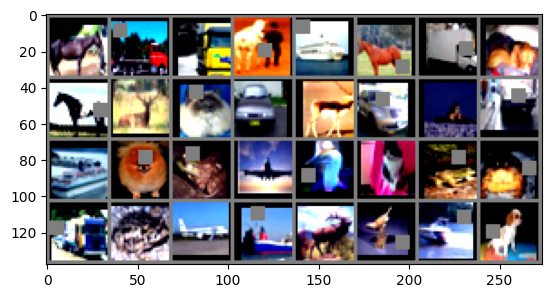

torch.Size([3, 32, 32])

horse truck truck horse ship  horse truck dog   horse deer  cat   car   deer  car   ship  car   ship  dog   frog  plane bird  cat   frog  frog  truck frog  plane ship  deer  bird  ship  dog  


In [21]:
%matplotlib inline

# Funcion para mostrar imagenes
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Tomar imagenes random
data_iter = iter(trainloader)
images, labels = next(data_iter)

# Mostramos imagenes
imshow(torchvision.utils.make_grid(images))

# Printeamos las etiquetas de las imagenes
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

image_size = images[0].shape
image_size


Invalid shape (3, 32, 32) for image data
torch.Size([3, 32, 32]) torch.Size([32, 32, 3])


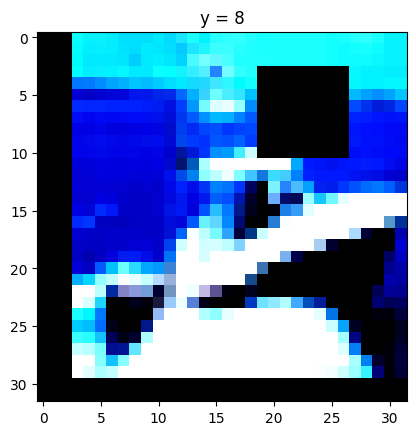

In [22]:
show_data(trainset[8])

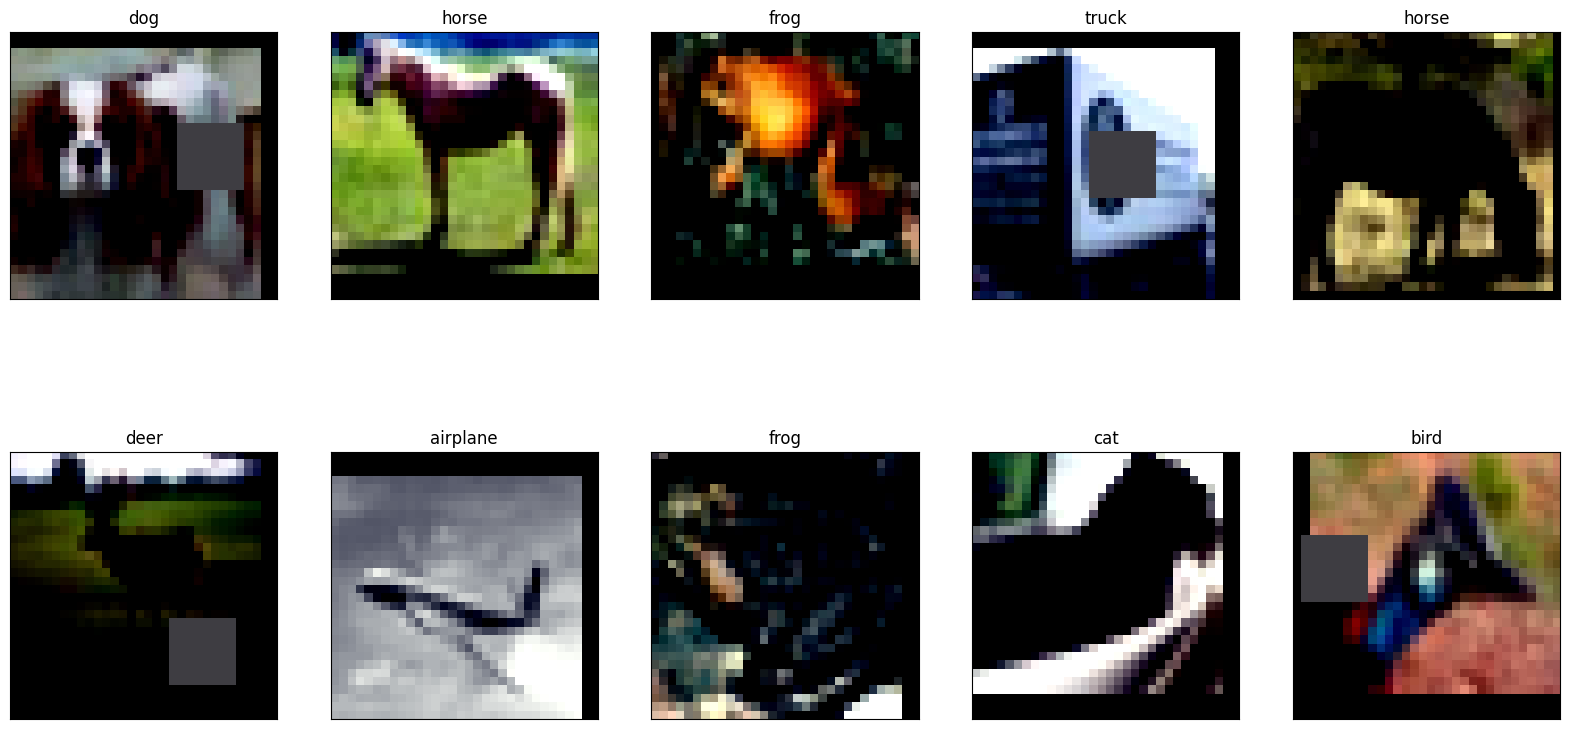

In [23]:
# Different classes in CIPHAR 10 dataset.
classes = ('airplane',
           'automobile',
           'bird',
           'cat',
           'deer',
           'dog',
           'frog',
           'horse',
           'ship',
           'truck')

# Define an iterable on the data
data_iterable = iter(trainloader) # converting our train_dataloader to iterable so that we can iter through it.
images, labels = next(data_iterable) #going from 1st batch of 100 images to the next batch
fig = plt.figure(figsize=(20, 10))

# Lets plot 50 images from our train_dataset
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])

    # Note: imshow cant print tensor !
    # Lets convert tensor image to numpy using im_convert function for imshow to print the image
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

## 2. Arquitectura
Realizar experimentos variando cantidad de capas densas, nodos, hidden layers y reportar el mejor y peor experimento. ¿Qué estrategia utilizaron? ¿Qué resultados obtuvieron?

In [24]:
if experiment_name == "MLP" and arquitectura:
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(32*32*3, 32*32*3)
            self.fc21 = nn.Linear(32*32*3, 32*32)
            self.fc22 = nn.Linear(32*32, 120)
            self.fc23 = nn.Linear(120, 120)
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, num_classes) # termina con 10 para quedarse con la mejor

        def forward(self, x):
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc21(x))
            x = F.relu(self.fc22(x))
            x = F.relu(self.fc23(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x



In [25]:
if experiment_name == "fc_hl_bigvalues"and arquitectura:
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(32*32*3, 32*32*3)
            self.fc21 = nn.Linear(32*32*3, 32*32)
            self.fc22 = nn.Linear(32*32, 150)
            self.fc23 = nn.Linear(150, 150)
            self.fc2 = nn.Linear(150, 100)
            self.fc3 = nn.Linear(100, num_classes) # termina con 10 para quedarse con la mejor

        def forward(self, x):
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc21(x))
            x = F.relu(self.fc22(x))
            x = F.relu(self.fc23(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x



In [26]:
if experiment_name == "fc_hl_1layers" and arquitectura:
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(32*32*3, 32*32*3)
            self.fc21 = nn.Linear(32*32*3, 32*32)
            self.fc22 = nn.Linear(32*32, 300)
            self.fc23 = nn.Linear(300, 200)
            self.fc_hidden = nn.Linear(200, 120)  # Nueva capa oculta con 120 nodos
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, num_classes)

        def forward(self, x):
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc21(x))
            x = F.relu(self.fc22(x))
            x = F.relu(self.fc23(x))
            x = F.relu(self.fc_hidden(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x


In [27]:
if experiment_name == "fc_hl_bigvalues_and_2layers" and arquitectura:
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(32*32*3, 32*32*3)
            self.fc21 = nn.Linear(32*32*3, 32*32)
            self.fc22 = nn.Linear(32*32, 300)
            self.fc23 = nn.Linear(300, 200)
            self.fc_hidden12 = nn.Linear(200, 200)  # Nueva capa oculta con 120 nodos
            self.fc2 = nn.Linear(200, 120)
            self.fc_hidden23 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, num_classes)

        def forward(self, x):
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc21(x))
            x = F.relu(self.fc22(x))
            x = F.relu(self.fc23(x))
            x = F.relu(self.fc_hidden12(x))
            x = F.relu(self.fc2(x))
            x = F.relu(self.fc_hidden23(x))
            x = self.fc3(x)
            return x


In [28]:
if experiment_name == "fc_hl_less_values" and arquitectura:
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(32*32*3, 32*32*3)
            self.fc21 = nn.Linear(32*32*3, 32*32)
            self.fc22 = nn.Linear(32*32, 50)
            self.fc23 = nn.Linear(50, 50)
            self.fc2 = nn.Linear(50, 25)
            self.fc3 = nn.Linear(25, num_classes) # termina con 10 para quedarse con la mejor

        def forward(self, x):
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc21(x))
            x = F.relu(self.fc22(x))
            x = F.relu(self.fc23(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x


In [29]:
if experiment_name == "fc_hl_1layer_less" and arquitectura:
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(32*32*3, 32*32*3)
            self.fc21 = nn.Linear(32*32*3, 32*32)
            self.fc22 = nn.Linear(32*32, 120)
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, num_classes) # termina con 10 para quedarse con la mejor

        def forward(self, x):
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc21(x))
            x = F.relu(self.fc22(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x


In [30]:
if experiment_name == "fc_hl_1layerless_smallvalues" and arquitectura:
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(32*32*3, 32*32*3)
            self.fc21 = nn.Linear(32*32*3, 32*32)
            self.fc22 = nn.Linear(32*32, 50)
            self.fc2 = nn.Linear(50, 25)
            self.fc3 = nn.Linear(25, num_classes) # termina con 10 para quedarse con la mejor

        def forward(self, x):
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc21(x))
            x = F.relu(self.fc22(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x




In [31]:
for i in name_deep_net_exp:
    if experiment_name == i and arquitectura:
      step = 2
      net = Net()
      net.to(device)


## 3. Arquitectura CNN
Extienda el análisis utilizando capas convolucionales y reportar el mejor y peor experimento. ¿Cómo se compara?

In [32]:
if experiment_name == "cnn_lessvalues" and arquitectura_cnn:
    class NetConv(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(in_channels = 3, x_channels = 6,kernel_size = 5, stride = 1, padding = 1)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(in_channels = 6, x_channels = 16, kernel_size = 5, stride = 1, padding = 1)
            self.fc1 = nn.Linear(16 * 5 * 5, 50)
            self.fc21 = nn.Linear(50, 50)
            self.fc22 = nn.Linear(50, 50)
            self.fc23 = nn.Linear(50, 50)
            self.fc2 = nn.Linear(50, 25)
            self.fc3 = nn.Linear(25, num_classes)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc21(x))
            x = F.relu(self.fc22(x))
            x = F.relu(self.fc23(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x


In [33]:
if experiment_name == "cnn_3convlayers"and arquitectura_cnn:
    class NetConv(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(in_channels = 3, x_channels = 6,kernel_size = 5, stride = 1, padding = 1)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(in_channels = 6, x_channels = 16, kernel_size = 2, stride = 2, padding = 1)
            self.pool1 = nn.MaxPool2d(2, 2)
            self.conv3 = nn.Conv2d(in_channels = 6, x_channels = 16, kernel_size = 2, stride = 1, padding = 1)
            self.fc1 = nn.Linear(16 * 5 * 5, 50)
            self.fc2 = nn.Linear(50, 50)
            self.fc3 = nn.Linear(50, 50)
            self.out = nn.Linear(25, num_classes)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = F.relu(self.fc3(x))
            x = self.out(x)
            return x

In [34]:

if experiment_name == "CNN_LeNet-5"and arquitectura_cnn:
    class NetConv(nn.Module):
        def __init__(self):
            super(NetConv, self).__init__()
            self.conv1 = nn.Conv2d(in_channels=3, x_channels=32, kernel_size=5, padding=2)
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.conv2 = nn.Conv2d(in_channels=32, x_channels=48, kernel_size=5)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.fc1 = nn.Linear(1728, 256)  # Adjusted xput size to 256
            self.fc2 = nn.Linear(256, 84)
            self.fc3 = nn.Linear(84, num_classes)

        def forward(self, x):
            x = self.pool1(F.relu(self.conv1(x)))
            x = self.pool2(F.relu(self.conv2(x)))
            x = x.view(x.size(0), -1)  # Flatten the tensor
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x



In [35]:
if experiment_name == "CNN_ResNet-18"and arquitectura_cnn:
  class BasicBlock(nn.Module):
      expansion = 1

      def __init__(self, in_planes, planes, stride=1):
          super(BasicBlock, self).__init__()
          self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
          self.bn1 = nn.BatchNorm2d(planes)
          self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
          self.bn2 = nn.BatchNorm2d(planes)
          self.shortcut = nn.Sequential()
          if stride != 1 or in_planes != self.expansion * planes:
              self.shortcut = nn.Sequential(
                  nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                  nn.BatchNorm2d(self.expansion * planes)
              )

      def forward(self, x):
          out = F.relu(self.bn1(self.conv1(x)))
          out = self.bn2(self.conv2(out))
          out += self.shortcut(x)
          out = F.relu(out)
          return out

  class NetConv(nn.Module):
      def __init__(self, num_classes=10):
          super(NetConv, self).__init__()
          self.in_planes = 64

          self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
          self.bn1 = nn.BatchNorm2d(64)
          self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
          self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
          self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
          self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
          self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
          self.fc = nn.Linear(512, num_classes)

      def _make_layer(self, block, planes, num_blocks, stride):
          strides = [stride] + [1] * (num_blocks - 1)
          layers = []
          for stride in strides:
              layers.append(block(self.in_planes, planes, stride))
              self.in_planes = planes * block.expansion
          return nn.Sequential(*layers)

      def forward(self, x):
          x = F.relu(self.bn1(self.conv1(x)))
          x = self.layer1(x)
          x = self.layer2(x)
          x = self.layer3(x)
          x = self.layer4(x)
          x = self.avgpool(x)
          x = x.view(x.size(0), -1)
          x = self.fc(x)
          return x




In [36]:
if experiment_name == "CNN_VGG16"and arquitectura_cnn:
    import torchvision.models as models
    # class NetConv(nn.Module):
    #     def __init__(self):
    #         super(NetConv, self).__init__()
    #         self.vgg16 = models.vgg16(pretrained=False)
    #         num_ftrs = self.vgg16.classifier[6].in_features
    #         self.vgg16.classifier[6] = nn.Linear(num_ftrs, 10)

    #     def forward(self, x):
    #         return self.vgg16(x)

    class NetConv(nn.Module):
        def __init__(self, num_classes=10):
            super(NetConv, self).__init__()

            self.transform = transforms.Compose(
                [
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                ]
            )

            self.layer1 = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU())
            self.layer2 = nn.Sequential(
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 2, stride = 2))
            self.layer3 = nn.Sequential(
                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU())
            self.layer4 = nn.Sequential(
                nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 2, stride = 2))
            self.layer5 = nn.Sequential(
                nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU())
            self.layer6 = nn.Sequential(
                nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU())
            self.layer7 = nn.Sequential(
                nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 2, stride = 2))
            self.layer8 = nn.Sequential(
                nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU())
            self.layer9 = nn.Sequential(
                nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU())
            self.layer10 = nn.Sequential(
                nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 2, stride = 2))
            self.layer11 = nn.Sequential(
                nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU())
            self.layer12 = nn.Sequential(
                nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU())

            self.layer13 = nn.Sequential(
                nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 2, stride = 2))

            self.fc = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(512, 4096),
                nn.ReLU())

            self.fc1 = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(4096, 4096),
                nn.ReLU())
            self.fc2= nn.Sequential(
                nn.Linear(4096, num_classes))

        def forward(self, x):
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)
            x = self.layer5(x)
            x = self.layer6(x)
            x = self.layer7(x)
            x = self.layer8(x)
            x = self.layer9(x)
            x = self.layer10(x)
            x = self.layer11(x)
            x = self.layer12(x)
            x = self.layer13(x)
            x = x.reshape(x.size(0), -1)
            x = self.fc(x)
            x = self.fc1(x)
            x = self.fc2(x)
            return x


In [37]:
if experiment_name == "CNN_SqueezeNet"and arquitectura_cnn:
    class FireModule(nn.Module):
        def __init__(self, in_channels, s1x1, e1x1, e3x3):
            super(FireModule, self).__init__()
            self.squeeze = nn.Conv2d(in_channels=in_channels, out_channels=s1x1, kernel_size=1, stride=1)
            self.expand1x1 = nn.Conv2d(in_channels=s1x1, out_channels=e1x1, kernel_size=1)
            self.expand3x3 = nn.Conv2d(in_channels=s1x1, out_channels=e3x3, kernel_size=3, padding=1)

        def forward(self, x):
            x = F.relu(self.squeeze(x))
            x1 = self.expand1x1(x)
            x2 = self.expand3x3(x)
            x = F.relu(torch.cat((x1, x2), dim=1))
            return x
    class NetConv(nn.Module):
        def __init__(self, out_channels):
            super(NetConv, self).__init__()
            self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=7, stride=2)
            self.max_pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

            self.fire2 = FireModule(in_channels=96, s1x1=16, e1x1=64, e3x3=64)
            self.fire3 = FireModule(in_channels=128, s1x1=16, e1x1=64, e3x3=64)
            self.fire4 = FireModule(in_channels=128, s1x1=32, e1x1=128, e3x3=128)
            self.max_pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

            self.fire5 = FireModule(in_channels=256, s1x1=32, e1x1=128, e3x3=128)
            self.fire6 = FireModule(in_channels=256, s1x1=48, e1x1=192, e3x3=192)
            self.fire7 = FireModule(in_channels=384, s1x1=48, e1x1=192, e3x3=192)
            self.fire8 = FireModule(in_channels=384, s1x1=64, e1x1=256, e3x3=256)
            self.max_pool3 = nn.MaxPool2d(kernel_size=3, stride=2)

            self.fire9 = FireModule(in_channels=512, s1x1=64, e1x1=256, e3x3=256)
            self.dropout = nn.Dropout(p=0.5)
            self.conv10 = nn.Conv2d(in_channels=512, out_channels=out_channels, kernel_size=1, stride=1)
            self.avg_pool = nn.AvgPool2d(kernel_size=12, stride=1)
            # We don't have FC Layers, inspired by NiN architecture.

        def forward(self, x):
            # First max pool after conv1
            x = self.max_pool1(self.conv1(x))
            # Second max pool after fire4
            x = self.max_pool2(self.fire4(self.fire3(self.fire2(x))))
            # Third max pool after fire8
            x = self.max_pool3(self.fire8(self.fire7(self.fire6(self.fire5(x)))))
            # Final pool (avg in this case) after conv10
            x = self.avg_pool(self.conv10(self.fire9(x)))
            return torch.flatten(x, start_dim=1)

In [38]:
for i in name_conv_net_exp:
    if experiment_name == i and arquitectura_cnn:
      step = 3
      # net = NetConv(num_classes)
      net = NetConv()
      net.to(device)

## 4. Funciones de activacion


vamos a utilizar ResNet-18 la cal presente mejor rendimiento de las arquitecturas CNN. Ahora en esta etapa ba vamos a experimentar con otra funciones de activacion.

In [39]:
if activacion_experiment:
  experiment_name = 'CNN_ResNet-18'
  funcion_activacion = 'relu6'

#leaky_relu
#relu
#relu6
#elu
#tanh
#silu
#sigmoid
#softmax

In [40]:

if experiment_name == "CNN_ResNet-18" and activacion_experiment:
    step = 4
    funcion_activacion = 'relu6'
    class BasicBlock(nn.Module):
        expansion = 1


        def __init__(self, in_planes, planes, stride=1):
            super(BasicBlock, self).__init__()

            self.conv1 = nn.Conv2d(
                in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                                  stride=1, padding=1, bias=False)
            self.bn2 = nn.BatchNorm2d(planes)

            self.shortcut = nn.Sequential()
            if stride != 1 or in_planes != self.expansion*planes:
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_planes, self.expansion*planes,
                              kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(self.expansion*planes),
                )

        def forward(self, x):
            out = F.relu6(self.dropout(self.bn1(self.conv1(x))))
            out = self.dropout(self.bn2(self.conv2(out)))
            out += self.shortcut(x)
            out = F.relu6(out)
            return out


    class ResNet(nn.Module):
        def __init__(self, block, num_blocks, num_classes=10):
            super(ResNet, self).__init__()
            self.in_planes = 64

            self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                                  stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(64)
            self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
            self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
            self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
            self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
            self.linear = nn.Linear(512*block.expansion, num_classes)

        def _make_layer(self, block, planes, num_blocks, stride):
            strides = [stride] + [1]*(num_blocks-1)
            layers = []
            for stride in strides:
                layers.append(block(self.in_planes, planes, stride))
                self.in_planes = planes * block.expansion
            return nn.Sequential(*layers)

        def forward(self, x):
            out = F.relu6(self.bn1(self.conv1(x)))
            out = self.layer1(out)
            out = self.layer2(out)
            out = self.layer3(out)
            out = self.layer4(out)
            out = F.avg_pool2d(out, 4)
            out = out.view(out.size(0), -1)
            out = self.linear(out)
            return F.log_softmax(out, dim=-1)


    def ResNet18():
        return ResNet(BasicBlock, [2, 2, 2, 2])

    net = ResNet18().to(device)
    summary(net, input_size=(3,32,32))



## 5. Optimizadores
Realizar experimentos evaluando distintos optimizadores, schedulers y reportar el mejor y peor experimento. ¿Qué estrategia utilizaron? ¿Qué resultados obtuvieron?

### Optimizadores

In [41]:
if optimizar:
    step = 5
    # funcion_activacion = 'leaky_relu'
    ## Parámetros de entrenamiento
    learning_rate = 0.01
    momentum = 0.9
    epochs = 10

    # Optimizador y función de pérdida
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
    # optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    # optimizer = optim.Adagrad(net.parameters(), lr=learning_rate, lr_decay=0.005, weight_decay=0.005)
    # optimizer = optim.RMSprop(net.parameters(), lr=learning_rate, momentum=momentum, weight_decay=0.005)
    # optimizer = optim.Adadelta(net.parameters(), lr=learning_rate, rho=0.9, eps=1e-06, weight_decay=0.005)


### Schedulers

In [42]:
if optimizar:
    # scheduler1 = ExponentialLR(optimizer, gamma=0.9)
    scheduler1 = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)
    # scheduler1 = ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
    # scheduler1 = StepLR(optimizer, step_size=15, gamma=0.1)

## 6. Entrenamiento - Mejora de parametros (lr, epochs, batchsize)
Realizar experimentos evaluando distintos batch-sizes, epochs y reportar el mejor y peor experimento. ¿Qué resultados obtuvieron?

In [43]:
if mejoras_lr:
    step = 6
    import random
    from itertools import product

    funcion_activacion = 'relu6'
    class BasicBlock(nn.Module):
        expansion = 1


        def __init__(self, in_planes, planes, stride=1):
            super(BasicBlock, self).__init__()

            DROPOUT = 0.1 # aplicamos Droput del 10% de las neuronas

            self.conv1 = nn.Conv2d(
                in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(planes)
            self.dropout = nn.Dropout(DROPOUT)
            self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                                stride=1, padding=1, bias=False)
            self.bn2 = nn.BatchNorm2d(planes)
            self.dropout = nn.Dropout(DROPOUT)

            self.shortcut = nn.Sequential()
            if stride != 1 or in_planes != self.expansion*planes:
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_planes, self.expansion*planes,
                            kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(self.expansion*planes),
                    nn.Dropout(DROPOUT)
                )

        def forward(self, x):
            out = F.relu6(self.dropout(self.bn1(self.conv1(x))))
            out = self.dropout(self.bn2(self.conv2(out)))
            out += self.shortcut(x)
            out = F.relu6(out)
            return out


    class ResNet(nn.Module):
        def __init__(self, block, num_blocks, num_classes=10):
            super(ResNet, self).__init__()
            self.in_planes = 64

            self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                                stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(64)
            self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
            self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
            self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
            self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
            self.linear = nn.Linear(512*block.expansion, num_classes)

        def _make_layer(self, block, planes, num_blocks, stride):
            strides = [stride] + [1]*(num_blocks-1)
            layers = []
            for stride in strides:
                layers.append(block(self.in_planes, planes, stride))
                self.in_planes = planes * block.expansion
            return nn.Sequential(*layers)

        def forward(self, x):
            out = F.relu6(self.bn1(self.conv1(x)))
            out = self.layer1(out)
            out = self.layer2(out)
            out = self.layer3(out)
            out = self.layer4(out)
            out = F.avg_pool2d(out, 4)
            out = out.view(out.size(0), -1)
            out = self.linear(out)
            return F.log_softmax(out, dim=-1)


    def ResNet18():
        return ResNet(BasicBlock, [2, 2, 2, 2])


    # Define the range of hyperparameters you want to search over
    learning_rate_range = [0.001, 0.002, 0.005,0.01,0.02,0.05,0.1]
    momentum_range = [0.6 + i * 0.05 for i in range(6)]
    weight_decay_range = [1e-2, 1e-3, 1e-4, 1e-5]  # Adjust the values as needed
    epochs_range = [3] #list(range(10, 30, 5))
    batch_size_values = [8, 16, 32, 64, 128, 256, 512]

    # Define the number of experiments you want to run
    num_experiments = 10


    def train_and_evaluate(epochs, learning_rate, momentum, weight_decay, experiment_name, batch_size, epsilon=0.001):
        trainset = create_trainset(root='./data', transform=composed_train)
        trainloader, valloader = create_loaders(trainset, batch_size=batch_size)
        net = ResNet18().to(device)
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
        scheduler1 = ExponentialLR(optimizer, gamma=0.9)
        criterion = nn.CrossEntropyLoss()

        # Initialize early stopping parameters
        best_val_loss = float('inf')
        consecutive_no_improvement = 0

        # Set up your wandb run here with the appropriate project and name
        experiment_name = f"{step}.{experiment_name} {funcion_activacion} {optimizer.__class__.__name__} lr={learning_rate} batch_size={batch_size} weight_decay={weight_decay}"

        try:
            wandb.init(
                project=project_name,
                name=experiment_name,
                config={
                    "learning_rate": learning_rate,
                    "momentum": momentum,
                    "batch_size": batch_size,
                    "epochs": epochs,
                },
            )

            for epoch in range(epochs):
                running_loss = 0.0
                train_correct = 0
                total = 0
                for i, data in enumerate(trainloader, 0):
                    inputs, labels = data[0].to(device), data[1].to(device)

                    optimizer.zero_grad()
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)

                    if regularizadores:
                        loss = regularization(net, loss, l1_lambda=weight_decay, l2_lambda=weight_decay, L1=L1, L2=L2)

                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()
                    if i % 200 == 199:
                        print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')

                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    train_correct += (predicted == labels).sum().item()

                scheduler1.step()

                train_accuracy = 100 * train_correct / total
                running_loss = running_loss / total

                val_correct = 0
                total = 0
                val_loss = 0

                with torch.no_grad():
                    for data in valloader:
                        images, labels = data[0].to(device), data[1].to(device)
                        outputs = net(images)
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        val_correct += (predicted == labels).sum().item()
                        val_loss += criterion(outputs, labels).item()

                val_accuracy = 100 * val_correct / total
                val_loss = val_loss / total

                wandb.log({
                    "train_accuracy": train_accuracy,
                    "val_accuracy": val_accuracy,
                    "train_loss": running_loss,
                    "val_loss": val_loss
                })

                # Implement early stopping
                if val_loss < best_val_loss - epsilon:
                    best_val_loss = val_loss
                    consecutive_no_improvement = 0
                else:
                    consecutive_no_improvement += 1

                if consecutive_no_improvement >= 5:
                    print("Early stopping: Validation loss did not improve for 5 consecutive epochs.")
                    break  # Stop training
            #guardo el modelo
            PATH = f'./{experiment_name}.pth'
            metadata = generar_metadata(net,
                                        experiment_name,
                                        epochs,
                                        learning_rate,
                                        batch_size,
                                        momentum,
                                        optimizer,
                                        scheduler1,
                                        train_accuracy,
                                        running_loss,
                                        val_accuracy,
                                        val_loss,
                                        regularizadores_data = {'data_augmentation': data_augmentation,'weight_decay': weight_decay,'L1':L1,'L2':L2})
            save_data_to_json(metadata,f'{experiment_name}.json')
            print(metadata)
            print('Finished Training')
        except Exception as e:
            print(e)
        finally:
            wandb.finish()


    # Create a list of hyperparameter combinations to try
    hyperparameter_combinations = list(product(epochs_range,
        learning_rate_range, momentum_range, weight_decay_range,batch_size_values))

    # Shuffle the combinations for random search
    random.shuffle(hyperparameter_combinations)

    for step, (epochs, learning_rate, momentum, weight_decay,batch_size) in enumerate(hyperparameter_combinations[:num_experiments], 1):
        print(f'{experiment_name},epochs:{epochs}, learning_rate:{learning_rate}, momentum:{momentum}, weight_decay:{weight_decay},batch_size:{batch_size}')
        train_and_evaluate(epochs, learning_rate, momentum, weight_decay,experiment_name,batch_size)

## 7. Regularización
Evaluar alguna(s) técnica(s) de regularización. ¿Qué resultados obtuvieron?

a) L1 Regularization
l1_penalty = torch.nn.L1Loss(size_average=False)
reg_loss = 0
for param in model.parameters():
→reg_loss += l1_penalty(param)

factor = const_val #lambda
loss += factor * reg_loss

b) L2 Regularization
The weight_decay parameter applies L2 regularization while initialising optimizer. This adds regularization term to the loss function, with the effect of shrinking the parameter estimates, making the model simpler and less likely to overfit.

Para regularizar y evitar overfitting agregamos Dropout=0.2
.

### Dropout

In [44]:
if experiment_name == "CNN_ResNet-18" and regularizadores:
  funcion_activacion = 'relu6'
  step = 7
  class BasicBlock(nn.Module):
      expansion = 1


      def __init__(self, in_planes, planes, stride=1):
          super(BasicBlock, self).__init__()

          DROPOUT = 0.2 # aplicamos Droput del 0.2

          self.conv1 = nn.Conv2d(
              in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
          self.bn1 = nn.BatchNorm2d(planes)
          self.dropout = nn.Dropout(DROPOUT)
          self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                                stride=1, padding=1, bias=False)
          self.bn2 = nn.BatchNorm2d(planes)
          self.dropout = nn.Dropout(DROPOUT)

          self.shortcut = nn.Sequential()
          if stride != 1 or in_planes != self.expansion*planes:
              self.shortcut = nn.Sequential(
                  nn.Conv2d(in_planes, self.expansion*planes,
                            kernel_size=1, stride=stride, bias=False),
                  nn.BatchNorm2d(self.expansion*planes),
                  nn.Dropout(DROPOUT)
              )

      def forward(self, x):
          out = F.relu6(self.dropout(self.bn1(self.conv1(x))))
          out = self.dropout(self.bn2(self.conv2(out)))
          out += self.shortcut(x)
          out = F.relu6(out)
          return out


  class ResNet(nn.Module):
      def __init__(self, block, num_blocks, num_classes=10):
          super(ResNet, self).__init__()
          self.in_planes = 64

          self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                                stride=1, padding=1, bias=False)
          self.bn1 = nn.BatchNorm2d(64)
          self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
          self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
          self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
          self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
          self.linear = nn.Linear(512*block.expansion, num_classes)

      def _make_layer(self, block, planes, num_blocks, stride):
          strides = [stride] + [1]*(num_blocks-1)
          layers = []
          for stride in strides:
              layers.append(block(self.in_planes, planes, stride))
              self.in_planes = planes * block.expansion
          return nn.Sequential(*layers)

      def forward(self, x):
          out = F.relu6(self.bn1(self.conv1(x)))
          out = self.layer1(out)
          out = self.layer2(out)
          out = self.layer3(out)
          out = self.layer4(out)
          out = F.avg_pool2d(out, 4)
          out = out.view(out.size(0), -1)
          out = self.linear(out)
          return F.log_softmax(out, dim=-1)


  def ResNet18():
      return ResNet(BasicBlock, [2, 2, 2, 2])

  net = ResNet18().to(device)
  summary(net, input_size=(3,32,32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
           Dropout-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          36,864
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
        BasicBlock-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
          Dropout-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [45]:
if regularizadores:
    step = 7
    funcion_activacion = 'relu6'
    learning_rate = 0.001
    momentum = 0.7
    epochs = 15
    weight_decay = 1e-5

    # Optimizador y función de pérdida
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum,weight_decay = weight_decay)

    scheduler1 = ExponentialLR(optimizer, gamma=0.9)
    # scheduler2 = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

### L1 y L2

In [46]:
def regularization(net, loss, l1_lambda=0.0, l2_lambda=0.0, L1=False, L2=False):
    if L1:
        l1_norm = sum(param.abs().sum() for param in net.parameters())
        loss = loss + l1_lambda * l1_norm
    if L2:
        l2_reg = 0.0
        for param in net.parameters():
            l2_reg += torch.norm(param, p=2)
        loss = loss + l2_lambda * l2_reg
    return loss


In [47]:
L1 = False
L2 = False

### Data aguemntation
hecho en la parte 1. Configuracion

## 8. Entrenamiento

### Entrenamos

## Mejor caso

In [48]:
#parametros finales
if mejor:
  #parametros
  batch_size= 64
  momentum= 0.7
  learning_rate= 0.01
  epochs= 15
  experiment_name = 'CNN_ResNet-18 relu6 SGD lr=0.01 batch_size=64 weight_decay=0.0001'
  funcion_activacion= 'relu6'
  weight_decay = 0.0001
  optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum,weight_decay = weight_decay)
  scheduler1= scheduler1 = ExponentialLR(optimizer, gamma=0.9)

In [49]:
experiment_name


'CNN_ResNet-18 relu6 SGD lr=0.01 batch_size=64 weight_decay=0.0001'

In [50]:
if not mejor:
  experiment_name = str(step) +'.'+ experiment_name + " " +funcion_activacion +" "+ optimizer.__class__.__name__ +" "+ scheduler1.__class__.__name__
  experiment_name


In [51]:
wandb.finish()
wandb.init(
    # seteamos el projecto donde se va a guardar el experimento en wandb
    project=project_name,
    name=experiment_name,

    # trackeamos los hiperparámetros y las métricas
    config={
        "learning_rate": learning_rate,
        "momentum": momentum,
        "batch_size": batch_size,
        "epochs": epochs,
        },
)


In [52]:
try:
    for epoch in range(epochs):  # loop over the dataset multiple times
        # ---------------- SECCION DE TRAIN -----------------
        running_loss = 0.0
        train_correct = 0
        total = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            #inputs, labels = data
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            if regularizadores:
                loss = regularization(net, loss, l1_lambda=weight_decay, l2_lambda=weight_decay, L1=L1, L2=L2)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 200 == 199:    # print every 200 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        scheduler1.step()

        # End of test section
        # Val section
        train_accuracy = 100 * train_correct / total
        running_loss = running_loss/total

        # ---------------- SECCION DE VALIDACION ----------------
        val_correct = 0
        total = 0
        val_loss = 0
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in valloader:
                images, labels = data[0].to(device), data[1].to(device)
                # calculate outputs by running images through the network
                outputs = net(images)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_loss += criterion(outputs, labels).item()

        # End of test section

        val_accuracy = 100 * val_correct / total
        val_loss = val_loss / total

        wandb.log({
            "train_accuracy": train_accuracy,
            "val_accuracy": val_accuracy,
            "train_loss": running_loss,
            "val_loss": val_loss})

    print('Finished Training')
except Exception as e:
    print(e)
finally:
    wandb.finish()


[1,   200] loss: 0.203
[1,   400] loss: 0.387
[1,   600] loss: 0.559
[1,   800] loss: 0.719
[1,  1000] loss: 0.873
[1,  1200] loss: 1.019
[2,   200] loss: 0.134
[2,   400] loss: 0.267
[2,   600] loss: 0.394
[2,   800] loss: 0.518
[2,  1000] loss: 0.639
[2,  1200] loss: 0.755
[3,   200] loss: 0.108
[3,   400] loss: 0.218
[3,   600] loss: 0.323
[3,   800] loss: 0.428
[3,  1000] loss: 0.530
[3,  1200] loss: 0.634
[4,   200] loss: 0.094
[4,   400] loss: 0.189
[4,   600] loss: 0.284
[4,   800] loss: 0.377
[4,  1000] loss: 0.468
[4,  1200] loss: 0.556
[5,   200] loss: 0.087
[5,   400] loss: 0.173
[5,   600] loss: 0.255
[5,   800] loss: 0.339
[5,  1000] loss: 0.420
[5,  1200] loss: 0.499
[6,   200] loss: 0.077
[6,   400] loss: 0.153
[6,   600] loss: 0.231
[6,   800] loss: 0.308
[6,  1000] loss: 0.383
[6,  1200] loss: 0.457
[7,   200] loss: 0.070
[7,   400] loss: 0.142
[7,   600] loss: 0.213
[7,   800] loss: 0.281
[7,  1000] loss: 0.351
[7,  1200] loss: 0.419
[8,   200] loss: 0.068
[8,   400] 

train_accuracy,▁▄▅▆▆▆▇▇▇▇█████
train_loss,█▅▄▄▃▃▂▂▂▂▁▁▁▁▁
val_accuracy,▁▃▅▅▆▆▇▇▇▇█████
val_loss,█▆▄▄▃▃▂▂▂▂▂▁▁▁▁
train_accuracy,83.2125
train_loss,0.0151
val_accuracy,81.08
val_loss,0.01712


Ejemplo de guardar el modelo. Sin embargo lo deberiamos guardar para el que mejor dio en validation.

In [53]:
PATH = f'./{experiment_name}.pth'
torch.save(net.state_dict(), PATH)

## 9. Evaluación final
Evaluar el mejor modelo, es decir, el mejor de los ejercicios anteriores, con el set de test.

Files already downloaded and verified


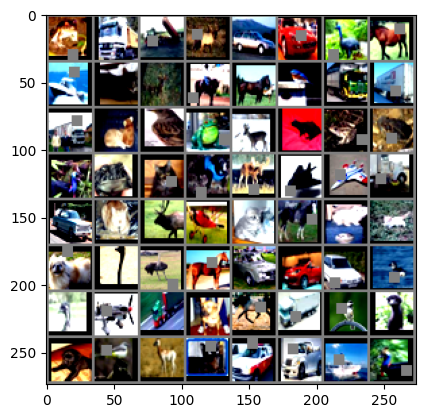

GroundTruth:  frog  truck truck deer  automobile automobile bird  horse ship  cat   deer  horse horse bird  truck truck truck cat   bird  frog  deer  cat   frog  frog  bird  frog  cat   dog   deer  airplane airplane truck automobile cat   deer  airplane cat   horse cat   cat   dog   bird  bird  horse automobile automobile automobile bird  bird  airplane truck dog   horse truck bird  bird  dog   bird  deer  cat   automobile automobile ship  bird 
Predicted:  frog  truck truck deer 
Accuracy of the network on the 10000 test test_images: 83 %


In [54]:
#Cargamos el modelo (el mejor) y evaluamos en un ejemplo
#net = Net()
net = ResNet18().to(device)
net.load_state_dict(torch.load(PATH))

#cargamos la data de test
if data_augmentation:
  testset = create_testset(root='./data', transform=composed_test)
else:
  testset = create_testset(root='./data', transform=transform)
testloader = create_testloader(trainset, batch_size=batch_size)

dataiter = iter(testloader)
data = next(dataiter)
test_images, test_labels = data

# print test_images
imshow(torchvision.utils.make_grid(test_images))
print("GroundTruth: ", " ".join(f"{classes[test_labels[j]]:5s}" for j in range(batch_size)))

test_images, test_labels = data[0].to(device), data[1].to(device)
outputs = net(test_images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        test_images, test_labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running test_images through the network
        outputs = net(test_images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += test_labels.size(0)
        correct += (predicted == test_labels).sum().item()

print(f"Accuracy of the network on the 10000 test test_images: {100 * correct // total} %")


In [55]:

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        test_images, test_labels = data[0].to(device), data[1].to(device)
        outputs = net(test_images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(test_labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    if total_pred[classname] != 0:
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f"Accuracy for class: {classname:5s} is {accuracy:.1f} %")
    else:
        print(f"No instances of class {classname} in the test dataset.")


Accuracy for class: airplane is 83.2 %
Accuracy for class: automobile is 92.3 %
Accuracy for class: bird  is 80.9 %
Accuracy for class: cat   is 70.4 %
Accuracy for class: deer  is 82.1 %
Accuracy for class: dog   is 71.8 %
Accuracy for class: frog  is 88.7 %
Accuracy for class: horse is 83.4 %
Accuracy for class: ship  is 93.5 %
Accuracy for class: truck is 92.2 %
